In [ ]:
!pip install menpo 0.11.0 #comment it if u have installed
!pip install menpofit
!pip install menpowidgets
!pip install menpodetect


In [ ]:
import numpy as np 
import pandas as pd
import sys
import io
import os
import cv2
import menpo.io as mio
import menpo
from imutils import face_utils
import imutils
import dlib
from google.colab import drive
from menpofit.aps import GenerativeAPS
from menpowidgets import visualize_images
from menpodetect import load_dlib_frontal_face_detector
import matplotlib.pyplot as plt
import urllib.request as urlreq
import matplotlib.pyplot as plt
from pylab import rcParams

In [ ]:
drive.mount('/content/gdrive', force_remount=True)
pwd = '/content/gdrive/MyDrive/Colab Notebooks'
sys.path.append(pwd)
%cd $pwd

Mounted at /content/gdrive
/content/gdrive/MyDrive/Colab Notebooks


In [ ]:
from menpofit.aam import LucasKanadeAAMFitter, WibergInverseCompositional
from menpofit.aam import PatchAAM
from menpo.visualize import print_progress

training_images = []
for img in print_progress(mio.import_images('dataset/trainset')):
  if(img.n_channels ==3):
    img =img.as_greyscale(mode = 'luminosity')
  img = img.crop_to_landmarks_proportion(0.5)
  d = img.diagonal()
  if d > 400:
    img = img.rescale(400.0/d)
  training_images.append(img)
  




[====================] 100% (811/811) - done.                                   


In [ ]:
from menpo.feature import imgfeature, igo

def custom_double_igo(image):
    return igo(image)

from menpofit.aam import PatchAAM
from menpo.feature import double_igo

patch_based_aam = PatchAAM(
    training_images,
    group='PTS',
    verbose=True,
    holistic_features=double_igo, 
    diagonal=120, 
    scales=(0.5, 1.0)
)

fitter = LucasKanadeAAMFitter(patch_based_aam, 
                              n_shape=[3, 12], 
                              n_appearance=50)


- Computing reference shape                                                     Computing batch 0
- Building models
  - Scale 0: Done
  - Scale 1: Done
                                                              

In [ ]:
from PIL import Image

def draw_lines(start, end, flag, image, result):
  array = result.to_result().final_shape.points[start:end]
  if flag == True:
    array = np.append(array, np.reshape(array[0],(1,2)), axis=0)
    
  for i in range(len(array) - 1):
    p1 = array[i]
    # print(p1[0], p1[1])
    p2 = array[i + 1]
    # print(p2[0], p2[1])
    # if p1[0] != p2[0]:
    slope = (p1[1]-p2[1])/(p1[0]-p2[0])
    # print(slope)
    intercept = p1[1] - slope*p1[0]
    # print(intercept)
    if p1[0] < p2[0]:
      for j in np.arange(float(p1[0]), float(p2[0]), 0.001):
        x = min(int(np.round(j)), 223)
        # print(x)
        y = min(int(np.round(slope*j + intercept)), 223)
        # print(y)
        image[x,y] = 255
    else:
      for j in np.arange(float(p2[0]), float(p1[0]), 0.001):
        x = min(int(np.round(j)), 223)
        # print(x)
        y = min(int(np.round(slope*j + intercept)), 223)
        # print(y)
        image[x,y] = 255

def saveImg(result, name):
  image = np.zeros((224,224), dtype=np.uint8)
  image.fill(0)
  # 0-17 face 
  draw_lines(0, 17, False, image, result)
  # 17-26 eyebrow
  draw_lines(17, 27, False, image, result)
  # 27-35 nose (27-30; 31-35)
  draw_lines(27, 31, False, image, result)
  draw_lines(31, 36, False, image, result)
  # 36-41 left eye
  draw_lines(36, 41, True, image, result)
  # 42-47 right eye
  draw_lines(42, 47, True, image, result)
  # 48-59 mouth outline
  draw_lines(48, 59, True, image, result)
  # 60-67 mouth inline
  draw_lines(60, 69, True, image, result)

  im = Image.fromarray(image)
  im.save(name + ".jpg")


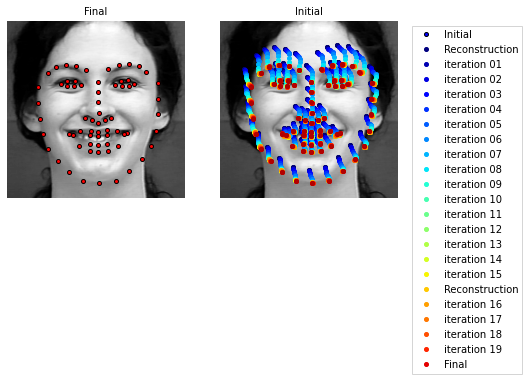

In [ ]:
image = mio.import_image("dataset/testset/happiness/S138_005_00000016.png")
detect = load_dlib_frontal_face_detector()
bboxes = detect(image)
initial_bbox = bboxes[0]
result = fitter.fit_from_bb(image, initial_bbox, max_iters=[15,5])
result.view()
# print(result.to_result().final_shape.points)
result.view(render_initial_shape=True)
result.view_iterations()
# saveImg(result, "S138_005_00000016_result")
image = np.zeros((224,224), dtype=np.uint8)
image.fill(0)
for point in result.to_result().final_shape.points:
  x = min(int(np.round(point[0])), 223)
  y = min(int(np.round(point[1])), 223)
  image[x,y] = 255

In [ ]:
import matplotlib.pyplot as plt
from skimage import io
from menpodetect import load_opencv_frontal_face_detector
from tqdm import tqdm
from PIL import Image

# i = 0
# for filename in sorted(os.listdir("fer_ckplus_kdef/happiness")):
#   if filename.endswith("png"): 
#     image = mio.import_image("fer_ckplus_kdef/happiness/" + filename)
#     detect = load_dlib_frontal_face_detector()
#     bboxes = detect(image) 
#     if(len(bboxes) == 0):
#       continue
#     initial_bbox = bboxes[0]
#     result = fitter.fit_from_bb(image, initial_bbox, max_iters=[15,5])
#     # result.view()
#     # print(result.to_result().final_shape.points)
#     saveImg(result, "fer/happiness/" + filename[:-4] + "_result")
#     print(i)
#     i = i + 1
#     if i == 200:
#       break




In [ ]:
i = 0
for filename in sorted(os.listdir("fer_ckplus_kdef/sadness")):
  if filename.endswith("png"): 
    image = mio.import_image("fer_ckplus_kdef/sadness/" + filename)
    detect = load_dlib_frontal_face_detector()
    bboxes = detect(image)
    if(len(bboxes) == 0):
      continue
    initial_bbox = bboxes[0]
    result = fitter.fit_from_bb(image, initial_bbox, max_iters=[15,5])
    # result.view()
    # print(result.to_result().final_shape.points)
    saveImg(result, "fer/sadness/" + filename[:-4] + "_result")
    print(i)
    i = i + 1
    if i == 200:
      break


In [ ]:
i = 0
for filename in os.listdir("fer_ckplus_kdef/contempt"):
  if filename.endswith("png"): 
    image = mio.import_image("fer_ckplus_kdef/contempt/" + filename)
    detect = load_dlib_frontal_face_detector()
    bboxes = detect(image)
    if(len(bboxes) == 0):
      continue
    initial_bbox = bboxes[0]
    result = fitter.fit_from_bb(image, initial_bbox, max_iters=[15,5])
    # result.view()
    # print(result.to_result().final_shape.points)
    saveImg(result, "fer/contempt/" + filename[:-4] + "_result")
    print(i)
    i = i + 1
    if i == 501:
      break

In [ ]:
i = 0
for filename in sorted(os.listdir("fer_ckplus_kdef/surprise")):
  if filename.endswith("png"): 
    image = mio.import_image("fer_ckplus_kdef/surprise/" + filename)
    detect = load_dlib_frontal_face_detector()
    bboxes = detect(image)
    if(len(bboxes) == 0):
      continue
    initial_bbox = bboxes[0]
    result = fitter.fit_from_bb(image, initial_bbox, max_iters=[15,5])
    # result.view()
    # print(result.to_result().final_shape.points)
    saveImg(result, "fer/surprise/" + filename[:-4] + "_result")
    print(i)
    i = i + 1
    if i == 501:
      break

In [ ]:
i = 0
for filename in sorted(os.listdir("fer_ckplus_kdef/anger")):
  if filename.endswith("png"): 
    image = mio.import_image("fer_ckplus_kdef/anger/" + filename)
    detect = load_dlib_frontal_face_detector()
    bboxes = detect(image)
    if(len(bboxes) == 0):
      continue
    initial_bbox = bboxes[0]
    result = fitter.fit_from_bb(image, initial_bbox, max_iters=[15,5])
    # result.view()
    # print(result.to_result().final_shape.points)
    saveImg(result, "fer/anger/" + filename[:-4] + "_result")
    print(i)
    i = i + 1
    if i == 501:
      break

In [ ]:
i = 0
for filename in sorted(os.listdir("fer_ckplus_kdef/disgust")):
  if filename.endswith("png"): 
    image = mio.import_image("fer_ckplus_kdef/disgust/" + filename)
    detect = load_dlib_frontal_face_detector()
    bboxes = detect(image)
    if(len(bboxes) == 0):
      continue
    initial_bbox = bboxes[0]
    result = fitter.fit_from_bb(image, initial_bbox, max_iters=[15,5])
    # result.view()
    # print(result.to_result().final_shape.points)
    saveImg(result, "fer/disgust/" + filename[:-4] + "_result")
    print(i)
    i = i + 1
    if i == 501:
      break